Notebook 3: Where we carry on explaining overfitting, now in the realm of  neural networks
------------------------------------------------------------------------------------------
We generate data from a "mistery polynomial" and we add some noise. Given the data, our goal is to obtain the best approximation to the data, not only the ones we train on but also fresh test data.

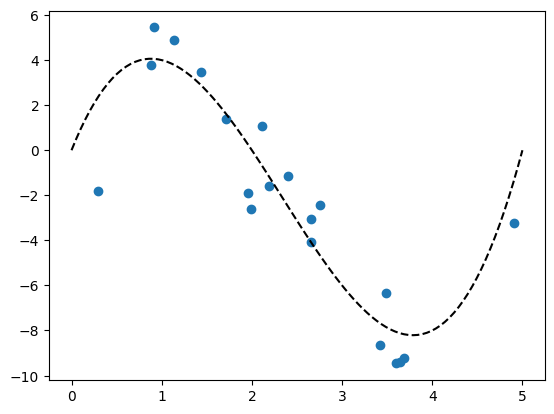

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from tqdm.notebook import tqdm

LOW_X = 0
HIGH_X = 5
np.random.seed(123)


def mistery_function(x):
    return x**3 - 7 * x**2 + 10 * x


def generate_data(num_data=20, noise=1.5):
    x_data = np.random.uniform(LOW_X, HIGH_X, num_data)
    y_data = mistery_function(x_data) + noise * np.random.randn(num_data)
    return torch.tensor(x_data).float(), torch.tensor(y_data).float()


x_train, y_train = generate_data()  # Training dataset
x_val, y_val = generate_data()  # Validation dataset

x_plot = torch.linspace(LOW_X, HIGH_X, 100)
y_plot = mistery_function(x_plot)
# x_val, y_val = generate_data(seed=2)

ax = plt.subplot()
ax.scatter(x_train, y_train)
_ = ax.plot(x_plot, y_plot, "--k")

In Pyotch, neural networks are initialised as instances of a class. Here, we define a class corresponding to a network shape that we want to train, and later define a network as an instance of such class.

The class needs an initialisation method, where the network layers are defined, and the forward pass. The backward pass is managed by autograd. It is possible to define custom layers with their associated forward and backward passes, and autograd will handle the backward pass using the chain rule.

In [2]:
class FirstNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.hidden_1 = nn.Sequential(
            nn.Linear(in_features=1, out_features=512),
            nn.ReLU()  # activation function
            # see others in https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
        )

        self.hidden_2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=512), nn.ReLU()
        )

        self.hidden_3 = nn.Sequential(
            nn.Linear(in_features=512, out_features=512), nn.ReLU()
        )

        self.output_layer = nn.Linear(in_features=512, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(
            len(x), 1
        )  # converts input to column vector for broadcasting to work
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.hidden_3(x)
        x = self.output_layer(x)

        return x.view(len(x))  # output returned as row vector again

And we implement the training loop.

In [3]:
def fit_network(
    network: nn.Module,
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    x_val: torch.Tensor,
    y_val: torch.Tensor,
    epochs: int,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
):
    train_loss, val_loss = [], []  # We will record the losses for plotting purposes

    with tqdm(
        range(epochs), unit="epoch"
    ) as tepochs:  # Loop that prints a progress bar for training
        tepochs.set_description("Training")
        for epoch in tepochs:
            # This is the training loop for each epoch

            network.train()  # Some layers work differently in training and evaluation,
            # so specifying we are training is good practice

            predicted = network(x_train)  # Compute network predictions
            optimizer.zero_grad()  # Forget gradients from last iteration
            loss = loss_fn(predicted, y_train)  # Computes loss and gradients
            loss.backward()  # Computes backward pass for gradients
            optimizer.step()  # Changes network parameters according to computed gradient

            train_loss.append(loss.item())  # Adds current loss to loss history

            network.eval()  # Changed network to evaluation mode for validation loss

            predicted_val = network(x_val)
            current_val_loss = loss_fn(predicted_val, y_val).item()

            val_loss.append(current_val_loss)

            tepochs.set_postfix(
                loss=loss.item()
            )  # Prints current training loss as part of progress bar

    return train_loss, val_loss

We can now use our training loop to train the network.

FirstNetwork(
  (hidden_1): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): ReLU()
  )
  (hidden_2): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (hidden_3): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=512, out_features=1, bias=True)
)


  0%|          | 0/5000 [00:00<?, ?epoch/s]

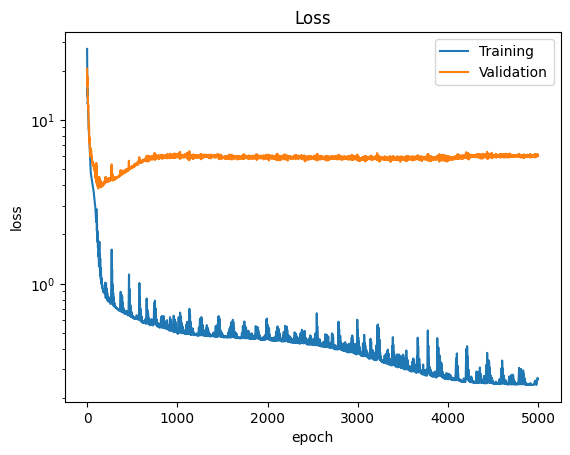

In [4]:
# We now initialise the network and select the optimizer and loss functions.
network = FirstNetwork()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
loss_funct = nn.MSELoss()

print(network)

train_loss, val_loss = fit_network(
    network,
    x_train,
    y_train,
    x_val,
    y_val,
    epochs=5000,
    optimizer=optimizer,
    loss_fn=loss_funct,
)

ax = plt.subplot()
ax.plot(train_loss, label="Training")
ax.plot(val_loss, label="Validation")
ax.set(title="Loss", yscale="log", ylabel="loss", xlabel="epoch")
_ = ax.legend()

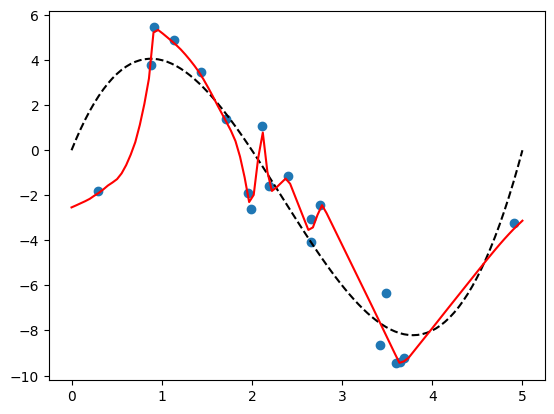

In [5]:
ax = plt.subplot()
ax.scatter(x_train, y_train)
ax.plot(x_plot, y_plot, "--k")
_ = ax.plot(x_plot, network.forward(x_plot).numpy(force=True), "r")

The neural network overfits.

As the training curves are noisy, we will reduce learning rate from $10^{-3}$ to $10^{-4}$. We will also modify our training loop to implement early stopping.

In [6]:
def fit_network_with_early_stopping(
    network: nn.Module,
    x_train: torch.Tensor,
    y_train: torch.Tensor,
    x_val: torch.Tensor,
    y_val: torch.Tensor,
    epochs: int,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    patience: int,
):
    train_loss, val_loss = [], []  # We will record the losses for plotting purposes

    number_worse = 0  # We save the number of times our validation loss gets worse after an iteration.
    # When we reach the patience, we break the training loop.
    best_val_loss = 1e10

    with tqdm(
        range(epochs), unit="epoch"
    ) as tepochs:  # Loop that prints a progress bar for training
        tepochs.set_description("Training")
        for epoch in tepochs:
            # This is the training loop for each epoch

            network.train()  # Some layers work differently in training and evaluation,
            # so specifying we are training is good practice

            predicted = network(x_train)  # Compute network predictions
            optimizer.zero_grad()  # Forget gradients from last iteration
            loss = loss_fn(predicted, y_train)  # Computes loss and gradients
            loss.backward()  # Computes backward pass for gradients
            optimizer.step()  # Changes network parameters according to computed gradient

            train_loss.append(loss.item())  # Adds current loss to loss history

            network.eval()  # Changed network to evaluation mode for validation loss

            predicted_val = network(x_val)
            current_val_loss = loss_fn(predicted_val, y_val).item()
            val_loss.append(current_val_loss)

            if current_val_loss < best_val_loss:
                best_val_loss = current_val_loss
                number_worse = 0
            else:
                number_worse += 1
                if number_worse >= patience:
                    print("Early stop.")
                    break

            tepochs.set_postfix(
                loss=loss.item()
            )  # Prints current training loss as part of progress bar

    return train_loss, val_loss

  0%|          | 0/5000 [00:00<?, ?epoch/s]

Early stop.


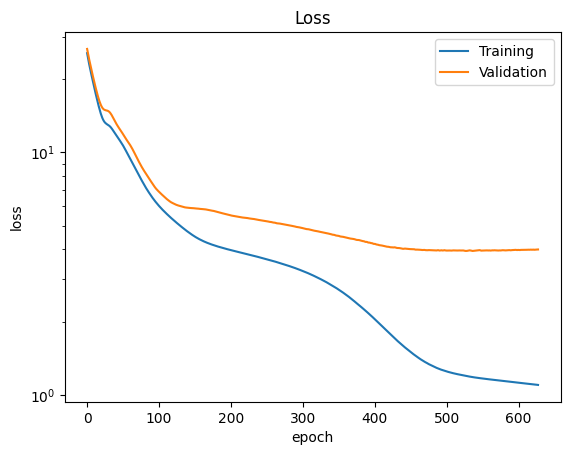

In [7]:
network = FirstNetwork()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
loss_funct = nn.MSELoss()

train_loss, val_loss = fit_network_with_early_stopping(
    network,
    x_train,
    y_train,
    x_val,
    y_val,
    epochs=5000,
    optimizer=optimizer,
    loss_fn=loss_funct,
    patience=100,
)

ax = plt.subplot()
ax.plot(train_loss, label="Training")
ax.plot(val_loss, label="Validation")
ax.set(title="Loss", yscale="log", ylabel="loss", xlabel="epoch")
_ = ax.legend()

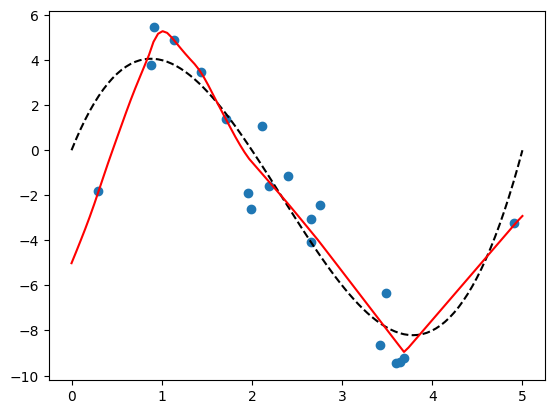

In [8]:
ax = plt.subplot()
ax.scatter(x_train, y_train)
ax.plot(x_plot, y_plot, "--k")
_ = ax.plot(x_plot, network.forward(x_plot).numpy(force=True), "r")

**Ex 1:** Change the neural network (number of layers, number of neurons, activation function) and the hyperparameters (learning rate, early-stopping, optimiser). There will be a competition, and the team minimising the error in a new test set that we will provide wins.